In [2]:
import raster_geometry as rg
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
import pickle
import sys
from skimage.transform import rescale, resize, downscale_local_mean
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
from SYMPTOMM.cell import Cell
from SYMPTOMM.scene_functions import create_space, step_and_update
from SYMPTOMM.plotting import matplot_scene
from SYMPTOMM.trench_geometry import trench_creator
import itertools
from joblib import Parallel, delayed
from skimage.morphology import opening
from PIL import Image       
import pymunk
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
from skimage import draw
#import napari
from itertools import combinations
from SYMPTOMM import PSF
from matplotlib_scalebar.scalebar import ScaleBar
from cupyx.scipy.ndimage import convolve as cuconvolve
import tifffile
from skimage.exposure import match_histograms
import cupy as cp
from scipy.optimize import dual_annealing, shgo
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from scipy.optimize import basinhopping
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr, fsim, issm, sre, sam, uiq
from SYMPTOMM.general_drawing import *
from SYMPTOMM.phase_contrast_drawing import *
div_odd = lambda n: (n//2, n//2 + 1)

In [ ]:
with open("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/output_pickles/cell_timeseries_short_trench.p", "rb") as f:
    cell_timeseries = pickle.load(f)
with open("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/output_pickles/space_timeseries_short_trench.p", "rb") as f:
    space = pickle.load(f)


In [404]:
def run_simulation(trench_length, trench_width, cell_max_length, cell_width):
    space = create_space()
    space.gravity = 0, -0.3
    dt = 1/100


    pix_mic_conv = 10 # pixels per micron
    scale_factor = 3 * pix_mic_conv

    trench_length = trench_length*scale_factor
    trench_width = trench_width*scale_factor
    trench_creator(trench_width,trench_length,(35,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*3,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*5,0),space) # Coordinates of bottom left corner of the trench

    cell1 = Cell(
        length = cell_max_length*scale_factor,  
        width = cell_width*scale_factor, 
        resolution = 60, 
        position = (20+35,40), 
        angle = 0.8, 
        space = space,
        dt = 1/60,
        growth_rate_constant = 1,
        max_length = cell_max_length*scale_factor,
        max_length_mean =cell_max_length*scale_factor,
        max_length_var = 0.1*np.sqrt(scale_factor),
        width_var = 0.03*np.sqrt(scale_factor),
        width_mean = cell_width*scale_factor
    )


    cells = [cell1]
    cell_timeseries = []
    phys_iters = 200
    for x in range(300):
        cells = step_and_update(dt=dt, cells=cells, space=space, phys_iters=phys_iters,ylim=trench_length)
        if x > 250:
            cell_timeseries.append(deepcopy(cells))
    return cell_timeseries, space


condensers = get_condensers()
W, R, diameter = condensers["Ph2"]
scale = 0.108379937 / 3 #0.35 #micron per pixel
min_sigma = 0.42*0.6/2 / scale # micron
#kernel= get_phase_contrast_kernel(R, W, 50, scale, 5, 15, 0.6)
#scalebar = ScaleBar(scale, 'um')
#plt.figure(figsize=(5.1,5.1))
#plt.gca().add_artist(scalebar)
#plt.imshow(kernel,cmap="Greys_r")
#plt.axis("off")
#plt.title("Phase Contrast")
#plt.show()
#kernel = cp.array(kernel)
#kernel_np = kernel.get()
#plt.figure(figsize = (15,10))
#plt.plot(np.arange(-50,51)*scale,kernel_np[50,:])
#plt.show()

In [240]:
cell_timeseries, space = run_simulation(trench_length=16.3, trench_width=1.4, cell_max_length=5.5, cell_width=0.9)
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=14)(delayed(gen_cell_props_for_draw)(a, ID_props) for a in cell_timeseries[-15:-1])
do_transformation = True
scenes = Parallel(n_jobs=14)(delayed(draw_scene)(cell_properties, do_transformation) for cell_properties in tqdm(cell_timeseries_properties))
OPL_scenes = [generate_PC_OPL(main_segments, offset, scene[0], trench_multiplier,cell_multiplier,background_multiplier) for scene in scenes]
OPL_scenes_convolved = np.array([convolve_rescale(OPL_scene,kernel,1) for OPL_scene in OPL_scenes])

100%|██████████| 14/14 [00:00<00:00, 10620.41it/s]


In [453]:
real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/trench_{}/T_{}.tif".format(
    str(np.random.randint(1,56)).zfill(2),
    str(np.random.randint(20,25)).zfill(3)))
real_image_shape = real_image.shape

In [364]:
#make convolved image and real image same shape
def make_images_same_shape(real_image,synthetic_image):
    x_diff = synthetic_image.shape[1] - real_image.shape[1]
    remove_from_left, remove_from_right = div_odd(x_diff)
    y_diff = synthetic_image.shape[0] - real_image.shape[0]
    if y_diff > 0:
        synthetic_image = synthetic_image[y_diff:,remove_from_left-1:-remove_from_right]
    else:
        synthetic_image = synthetic_image[:,remove_from_left-1:-remove_from_right]
        real_image = real_image[abs(y_diff):,:]
    return real_image, synthetic_image

In [450]:
def get_similarity_metrics(real_image,synthetic_image):
    synthetic_image = match_histograms(synthetic_image, real_image, multichannel=False)
    synthetic_image = resize(synthetic_image,real_image.shape,clip=False,preserve_range=False,anti_aliasing=None)
    synthetic_image = synthetic_image/np.max(synthetic_image)
    ssim_real = ssim(synthetic_image, real_image)
    intersection = return_intersection_between_image_hists(synthetic_image, real_image, 100)
    #sims 
    synthetic_image_ = deepcopy(synthetic_image)
    synthetic_image_.shape += (1,)
    
    real_image_ = deepcopy(real_image)
    real_image_.shape += (1,)
    _fsim = fsim(synthetic_image_,real_image_)
    _issm = issm(synthetic_image_,real_image_)
    _sam = sam(synthetic_image_,real_image_)
    _sre = sre(synthetic_image_,real_image_)
    objs = [ssim_real, 0.5*intersection, _fsim, _issm, _sam, _sre/20]
    return objs

In [460]:

def objective_function(z, ret_tuple = False):
    real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/top_trenches_PC/trench_{}/T_{}.tif".format(
    str(np.random.randint(1,56)).zfill(2),
    str(np.random.randint(20,25)).zfill(3)))
    
    real_image = real_image.astype(np.float64)/np.max(real_image)
    
    σ, trench_multiplier, cell_multiplier, background_multiplier, trench_length, trench_width, cell_max_length, cell_width = z
    print(z)
    
    cell_timeseries, space = run_simulation(trench_length, trench_width, cell_max_length, cell_width)
    main_segments = get_trench_segments(space)
    ID_props = generate_curve_props(cell_timeseries)
    cell_timeseries_properties = Parallel(n_jobs=14)(delayed(gen_cell_props_for_draw)(a, ID_props) for a in cell_timeseries[-5:-1])
    do_transformation = True
    scenes = Parallel(n_jobs=14)(delayed(draw_scene)(cell_properties, do_transformation) for cell_properties in tqdm(cell_timeseries_properties))

    
    #expanded_scene = generate_PC_OPL(trench_multiplier,cell_multiplier,background_multiplier)
    OPL_scenes = [generate_PC_OPL(main_segments, offset, scene[1], trench_multiplier,cell_multiplier,background_multiplier) for scene in scenes]
    
    kernel = get_phase_contrast_kernel(R, W, 50, scale, 5, σ,0.6)
    OPL_scenes_convolved = np.array([convolve_rescale(OPL_scene,kernel,1) for OPL_scene in OPL_scenes])
    
    
    #convolved_image = random_noise(convolved_image, mode="gaussian", mean=5,var=σ2,clip=False)
    OPL_scenes_convolved = np.array([match_histograms(OPL_scene_convolved, real_image, multichannel=False) for OPL_scene_convolved in OPL_scenes_convolved])
    all_objs = [get_similarity_metrics(*make_images_same_shape(real_image,OPL_scene_convolved)) for OPL_scene_convolved in OPL_scenes_convolved]
    objs = np.mean(all_objs,axis=0)
    #convolved_image = resize(convolved_image,real_image.shape,clip=False,preserve_range=False,anti_aliasing=None)
    #ssim_real = ssim(convolved_image, real_image)
    #intersection = return_intersection_between_image_hists(convolved_image, real_image, 100)
    #sims 
    #convolved_image.shape += (1,)
    #real_image.shape += (1,)
    #_fsim = fsim(convolved_image,real_image)
    #_issm = issm(convolved_image,real_image)
    #_sam = sam(convolved_image,real_image)
    #_sre = sre(convolved_image,real_image)
    #objs = [ssim_real, 0.5*intersection, _fsim, _issm, _sam, _sre/20]
    if ret_tuple == False:
        return -np.linalg.norm(objs)
    else:
        return objs, OPL_scenes_convolved

progress = []
def callbackF(x, f, context):
    print(x)
    progress.append(x)
    
def callbackSHGo(x):
    print(x)
    progress.append(x)

In [461]:
bounds = list(zip([min_sigma, 1.0, 0.2, 1, 14, 1.0, 3, 0.8], [20.0, 30.0, 5.0, 20.0, 17, 1.8, 6, 1.1]))

In [462]:
ret = shgo(objective_function, bounds = np.array(bounds),callback=callbackSHGo,options={"minimize_every_iter":True})
#ret = dual_annealing(objective_function, bounds = np.array(bounds),callback=callbackF,maxiter=1000,initial_temp=5*10**4)

[ 1.1625768  1.         0.2        1.        14.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 6602.60it/s]


[20.  30.   5.  20.  17.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6039.31it/s]


[20.   1.   0.2  1.  14.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8652.51it/s]


[20.  30.   0.2  1.  14.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9331.04it/s]


[20.  30.   5.   1.  14.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8719.97it/s]


[20.  30.   5.  20.  14.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7410.43it/s]


[20.  30.   5.  20.  17.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12768.05it/s]


[20.  30.   5.  20.  17.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12539.03it/s]


[20.  30.   5.  20.  17.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12131.03it/s]


[20.  30.   5.  20.  17.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 11675.17it/s]


[20.  30.   5.  20.  17.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9559.67it/s]


[20.  30.   5.  20.  17.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7377.84it/s]


[20.  30.   5.  20.  17.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7770.83it/s]


[20.  30.   5.  20.  14.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 5267.57it/s]


[20.  30.   5.  20.  14.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7650.35it/s]


[20.  30.   5.  20.  14.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6571.57it/s]


[20.  30.   5.  20.  14.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8830.11it/s]


[20.  30.   5.  20.  14.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 6335.81it/s]


[20.  30.   5.  20.  14.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9187.96it/s]


[20.  30.   5.  20.  14.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 10498.88it/s]


[20.  30.   5.   1.  17.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8326.16it/s]


[20.  30.   5.   1.  17.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12623.94it/s]


[20.  30.   5.   1.  17.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 10479.21it/s]


[20.  30.   5.   1.  17.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 13025.79it/s]


[20.  30.   5.   1.  17.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 10538.45it/s]


[20.  30.   5.   1.  17.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 6716.26it/s]


[20.  30.   5.   1.  17.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7767.23it/s]


[20.  30.   5.   1.  17.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7731.44it/s]


[20.  30.   5.   1.  14.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8876.83it/s]


[20.  30.   5.   1.  14.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12300.01it/s]


[20.  30.   5.   1.  14.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8957.40it/s]


[20.  30.   5.   1.  14.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 5218.42it/s]


[20.  30.   5.   1.  14.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9915.61it/s]


[20.  30.   5.   1.  14.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8376.04it/s]


[20.  30.   5.   1.  14.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 12652.50it/s]


[20.  30.   0.2 20.  14.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12139.81it/s]


[20.  30.   0.2 20.  17.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 10046.24it/s]


[20.  30.   0.2 20.  17.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12652.50it/s]


[20.  30.   0.2 20.  17.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12671.61it/s]


[20.  30.   0.2 20.  17.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8313.78it/s]


[20.  30.   0.2 20.  17.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 10058.28it/s]


[20.  30.   0.2 20.  17.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8027.38it/s]


[20.  30.   0.2 20.  17.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7574.36it/s]


[20.  30.   0.2 20.  17.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 12865.96it/s]


[20.  30.   0.2 20.  14.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 11707.76it/s]


[20.  30.   0.2 20.  14.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9029.72it/s]


[20.  30.   0.2 20.  14.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7660.83it/s]


[20.  30.   0.2 20.  14.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 12856.10it/s]


[20.  30.   0.2 20.  14.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8881.53it/s]


[20.  30.   0.2 20.  14.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6398.63it/s]


[20.  30.   0.2 20.  14.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9998.34it/s]


[20.  30.   0.2  1.  17.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7093.96it/s]


[20.  30.   0.2  1.  17.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9776.93it/s]


[20.  30.   0.2  1.  17.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7895.16it/s]


[20.  30.   0.2  1.  17.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6670.86it/s]


[20.  30.   0.2  1.  17.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 10236.25it/s]


[20.  30.   0.2  1.  17.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7231.56it/s]


[20.  30.   0.2  1.  17.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9223.32it/s]


[20.  30.   0.2  1.  17.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 12662.05it/s]


[20.  30.   0.2  1.  14.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12895.63it/s]


[20.  30.   0.2  1.  14.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7326.30it/s]


[20.  30.   0.2  1.  14.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8751.81it/s]


[20.  30.   0.2  1.  14.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 13056.20it/s]


[20.  30.   0.2  1.  14.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 5321.03it/s]


[20.  30.   0.2  1.  14.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 13551.87it/s]


[20.  30.   0.2  1.  14.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 5429.52it/s]


[20.   1.   5.   1.  14.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 6432.98it/s]


[20.   1.   5.  20.  14.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 11074.07it/s]


[20.   1.   5.  20.  17.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 11297.79it/s]


[20.   1.   5.  20.  17.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8634.70it/s]


[20.   1.   5.  20.  17.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7530.17it/s]


[20.   1.   5.  20.  17.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8004.40it/s]


[20.   1.   5.  20.  17.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 10768.43it/s]


[20.   1.   5.  20.  17.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7516.67it/s]


[20.   1.   5.  20.  17.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8966.98it/s]


[20.   1.   5.  20.  17.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6881.55it/s]


[20.   1.   5.  20.  14.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 10598.37it/s]


[20.   1.   5.  20.  14.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9974.56it/s]


[20.   1.   5.  20.  14.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 10375.52it/s]


[20.   1.   5.  20.  14.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 11382.10it/s]


[20.   1.   5.  20.  14.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7469.82it/s]


[20.   1.   5.  20.  14.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8551.08it/s]


[20.   1.   5.  20.  14.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6756.83it/s]


[20.   1.   5.   1.  17.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8443.49it/s]


[20.   1.   5.   1.  17.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9147.88it/s]


[20.   1.   5.   1.  17.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8413.85it/s]


[20.   1.   5.   1.  17.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9570.57it/s]


[20.   1.   5.   1.  17.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9238.56it/s]


[20.   1.   5.   1.  17.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8608.11it/s]


[20.   1.   5.   1.  17.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8516.35it/s]


[20.   1.   5.   1.  17.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 10255.02it/s]


[20.   1.   5.   1.  14.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9451.95it/s]


[20.   1.   5.   1.  14.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 13086.75it/s]


[20.   1.   5.   1.  14.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9383.23it/s]


[20.   1.   5.   1.  14.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7977.75it/s]


[20.   1.   5.   1.  14.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 7067.07it/s]


[20.   1.   5.   1.  14.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8456.26it/s]


[20.   1.   5.   1.  14.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9457.28it/s]


[20.   1.   0.2 20.  14.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12131.03it/s]


[20.   1.   0.2 20.  17.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8914.57it/s]


[20.   1.   0.2 20.  17.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 6355.01it/s]


[20.   1.   0.2 20.  17.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8443.49it/s]


[20.   1.   0.2 20.  17.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6973.07it/s]


[20.   1.   0.2 20.  17.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6870.28it/s]


[20.   1.   0.2 20.  17.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9720.29it/s]


[20.   1.   0.2 20.  17.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9167.88it/s]


[20.   1.   0.2 20.  17.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 8413.85it/s]


[20.   1.   0.2 20.  14.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12595.51it/s]


[20.   1.   0.2 20.  14.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12846.26it/s]


[20.   1.   0.2 20.  14.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 11538.66it/s]


[20.   1.   0.2 20.  14.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 10789.21it/s]


[20.   1.   0.2 20.  14.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 8220.10it/s]


[20.   1.   0.2 20.  14.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 13651.11it/s]


[20.   1.   0.2 20.  14.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 13606.83it/s]


[20.   1.   0.2  1.  17.   1.   3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 10267.57it/s]


[20.   1.   0.2  1.  17.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 11707.76it/s]


[20.   1.   0.2  1.  17.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 11602.50it/s]


[20.   1.   0.2  1.  17.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9409.54it/s]


[20.   1.   0.2  1.  17.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 12915.49it/s]


[20.   1.   0.2  1.  17.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 6944.21it/s]


[20.   1.   0.2  1.  17.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7410.43it/s]


[20.   1.   0.2  1.  17.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 6811.70it/s]


[20.   1.   0.2  1.  14.   1.8  3.   0.8]


100%|██████████| 4/4 [00:00<00:00, 9152.87it/s]


[20.   1.   0.2  1.  14.   1.8  6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 11305.40it/s]


[20.   1.   0.2  1.  14.   1.8  6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 5673.73it/s]


[20.   1.   0.2  1.  14.   1.8  3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 7384.34it/s]


[20.   1.   0.2  1.  14.   1.   6.   0.8]


100%|██████████| 4/4 [00:00<00:00, 12777.77it/s]


[20.   1.   0.2  1.  14.   1.   6.   1.1]


100%|██████████| 4/4 [00:00<00:00, 9238.56it/s]


[20.   1.   0.2  1.  14.   1.   3.   1.1]


100%|██████████| 4/4 [00:00<00:00, 5716.26it/s]


[ 1.1625768 30.         0.2        1.        14.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 5996.15it/s]


[ 1.1625768 30.         5.         1.        14.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 6398.63it/s]


[ 1.1625768 30.         5.        20.        14.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9172.89it/s]


[ 1.1625768 30.         5.        20.        17.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 13066.37it/s]


[ 1.1625768 30.         5.        20.        17.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12777.77it/s]


[ 1.1625768 30.         5.        20.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8692.86it/s]


[ 1.1625768 30.         5.        20.        17.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12035.31it/s]


[ 1.1625768 30.         5.        20.        17.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 13015.68it/s]


[ 1.1625768 30.         5.        20.        17.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 13015.68it/s]


[ 1.1625768 30.         5.        20.        17.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 7895.16it/s]


[ 1.1625768 30.         5.        20.        17.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9636.54it/s]


[ 1.1625768 30.         5.        20.        14.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9675.44it/s]


[ 1.1625768 30.         5.        20.        14.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9886.40it/s]


[ 1.1625768 30.         5.        20.        14.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 10446.59it/s]


[ 1.1625768 30.         5.        20.        14.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9714.66it/s]


[ 1.1625768 30.         5.        20.        14.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 6631.31it/s]


[ 1.1625768 30.         5.        20.        14.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12282.00it/s]


[ 1.1625768 30.         5.        20.        14.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8330.30it/s]


[ 1.1625768 30.         5.         1.        17.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 7803.36it/s]


[ 1.1625768 30.         5.         1.        17.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 13046.05it/s]


[ 1.1625768 30.         5.         1.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12510.97it/s]


[ 1.1625768 30.         5.         1.        17.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 10531.84it/s]


[ 1.1625768 30.         5.         1.        17.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12327.12it/s]


[ 1.1625768 30.         5.         1.        17.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 10248.76it/s]


[ 1.1625768 30.         5.         1.        17.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 10565.00it/s]


[ 1.1625768 30.         5.         1.        17.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 7345.54it/s]


[ 1.1625768 30.         5.         1.        14.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12865.96it/s]


[ 1.1625768 30.         5.         1.        14.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 6990.51it/s]


[ 1.1625768 30.         5.         1.        14.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 11538.66it/s]


[ 1.1625768 30.         5.         1.        14.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12905.55it/s]


[ 1.1625768 30.         5.         1.        14.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 7364.89it/s]


[ 1.1625768 30.         5.         1.        14.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 5581.24it/s]


[ 1.1625768 30.         5.         1.        14.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 7326.30it/s]


[ 1.1625768 30.         0.2       20.        14.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 13294.15it/s]


[ 1.1625768 30.         0.2       20.        17.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8355.19it/s]


[ 1.1625768 30.         0.2       20.        17.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 11958.10it/s]


[ 1.1625768 30.         0.2       20.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 6269.51it/s]


[ 1.1625768 30.         0.2       20.        17.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9956.80it/s]


[ 1.1625768 30.         0.2       20.        17.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 7940.00it/s]


[ 1.1625768 30.         0.2       20.        17.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8966.98it/s]


[ 1.1625768 30.         0.2       20.        17.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9675.44it/s]


[ 1.1625768 30.         0.2       20.        17.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12710.01it/s]


[ 1.1625768 30.         0.2       20.        14.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8770.11it/s]


[ 1.1625768 30.         0.2       20.        14.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12719.65it/s]


[ 1.1625768 30.         0.2       20.        14.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 5584.96it/s]


[ 1.1625768 30.         0.2       20.        14.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9548.79it/s]


[ 1.1625768 30.         0.2       20.        14.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9742.87it/s]


[ 1.1625768 30.         0.2       20.        14.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 10016.25it/s]


[ 1.1625768 30.         0.2       20.        14.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 6649.71it/s]


[ 1.1625768 30.         0.2        1.        17.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12026.68it/s]


[ 1.1625768 30.         0.2        1.        17.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8760.95it/s]


[ 1.1625768 30.         0.2        1.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 13117.45it/s]


[ 1.1625768 30.         0.2        1.        17.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 5203.85it/s]


[ 1.1625768 30.         0.2        1.        17.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9294.86it/s]


[ 1.1625768 30.         0.2        1.        17.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 10713.42it/s]


[ 1.1625768 30.         0.2        1.        17.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9543.35it/s]


[ 1.1625768 30.         0.2        1.        17.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 4996.19it/s]


[ 1.1625768 30.         0.2        1.        14.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 11562.52it/s]


[ 1.1625768 30.         0.2        1.        14.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9962.72it/s]


[ 1.1625768 30.         0.2        1.        14.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9289.71it/s]


[ 1.1625768 30.         0.2        1.        14.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 6721.64it/s]


[ 1.1625768 30.         0.2        1.        14.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 7081.98it/s]


[ 1.1625768 30.         0.2        1.        14.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 13651.11it/s]


[ 1.1625768 30.         0.2        1.        14.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9020.01it/s]


[ 1.1625768  1.         5.         1.        14.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9467.95it/s]


[ 1.1625768  1.         5.        20.        14.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 7222.22it/s]


[ 1.1625768  1.         5.        20.        17.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9331.04it/s]


[ 1.1625768  1.         5.        20.        17.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9754.20it/s]


[ 1.1625768  1.         5.        20.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 13273.11it/s]


[ 1.1625768  1.         5.        20.        17.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 7163.63it/s]


[ 1.1625768  1.         5.        20.        17.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9436.00it/s]


[ 1.1625768  1.         5.        20.        17.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8443.49it/s]


[ 1.1625768  1.         5.        20.        17.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 6405.96it/s]


[ 1.1625768  1.         5.        20.        17.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12576.62it/s]


[ 1.1625768  1.         5.        20.        14.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 10485.76it/s]


[ 1.1625768  1.         5.        20.        14.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9619.96it/s]


[ 1.1625768  1.         5.        20.        14.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 5380.76it/s]


[ 1.1625768  1.         5.        20.        14.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 11514.90it/s]


[ 1.1625768  1.         5.        20.        14.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 6058.94it/s]


[ 1.1625768  1.         5.        20.        14.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 6581.88it/s]


[ 1.1625768  1.         5.        20.        14.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12567.20it/s]


[ 1.1625768  1.         5.         1.        17.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 6932.73it/s]


[ 1.1625768  1.         5.         1.        17.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 5062.53it/s]


[ 1.1625768  1.         5.         1.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8648.05it/s]


[ 1.1625768  1.         5.         1.        17.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 11932.59it/s]


[ 1.1625768  1.         5.         1.        17.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 6613.01it/s]


[ 1.1625768  1.         5.         1.        17.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 7031.52it/s]


[ 1.1625768  1.         5.         1.        17.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 13454.06it/s]


[ 1.1625768  1.         5.         1.        17.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8116.70it/s]


[ 1.1625768  1.         5.         1.        14.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 11594.48it/s]


[ 1.1625768  1.         5.         1.        14.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9697.81it/s]


[ 1.1625768  1.         5.         1.        14.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 11008.67it/s]


[ 1.1625768  1.         5.         1.        14.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8112.77it/s]


[ 1.1625768  1.         5.         1.        14.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12700.39it/s]


[ 1.1625768  1.         5.         1.        14.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 10161.85it/s]


[ 1.1625768  1.         5.         1.        14.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8196.00it/s]


[ 1.1625768  1.         0.2       20.        14.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9619.96it/s]


[ 1.1625768  1.         0.2       20.        17.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9765.55it/s]


[ 1.1625768  1.         0.2       20.        17.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 13421.77it/s]


[ 1.1625768  1.         0.2       20.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8085.41it/s]


[ 1.1625768  1.         0.2       20.        17.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 11140.25it/s]


[ 1.1625768  1.         0.2       20.        17.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 11066.77it/s]


[ 1.1625768  1.         0.2       20.        17.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 6999.26it/s]


[ 1.1625768  1.         0.2       20.        17.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8132.44it/s]


[ 1.1625768  1.         0.2       20.        17.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 5138.50it/s]


[ 1.1625768  1.         0.2       20.        14.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 13294.15it/s]


[ 1.1625768  1.         0.2       20.        14.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12995.52it/s]


[ 1.1625768  1.         0.2       20.        14.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 11374.38it/s]


[ 1.1625768  1.         0.2       20.        14.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8042.77it/s]


[ 1.1625768  1.         0.2       20.        14.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12965.39it/s]


[ 1.1625768  1.         0.2       20.        14.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 10485.76it/s]


[ 1.1625768  1.         0.2       20.        14.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 9714.66it/s]


[ 1.1625768  1.         0.2        1.        17.         1.
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 11667.05it/s]


[ 1.1625768  1.         0.2        1.        17.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 12586.06it/s]


[ 1.1625768  1.         0.2        1.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9720.29it/s]


[ 1.1625768  1.         0.2        1.        17.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12945.38it/s]


[ 1.1625768  1.         0.2        1.        17.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12797.27it/s]


[ 1.1625768  1.         0.2        1.        17.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 7281.78it/s]


[ 1.1625768  1.         0.2        1.        17.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8783.88it/s]


[ 1.1625768  1.         0.2        1.        17.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 12777.77it/s]


[ 1.1625768  1.         0.2        1.        14.         1.8
  3.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 8590.48it/s]


[ 1.1625768  1.         0.2        1.        14.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 5329.48it/s]


[ 1.1625768  1.         0.2        1.        14.         1.8
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8101.02it/s]


[ 1.1625768  1.         0.2        1.        14.         1.8
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8371.86it/s]


[ 1.1625768  1.         0.2        1.        14.         1.
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 9420.11it/s]


[ 1.1625768  1.         0.2        1.        14.         1.
  6.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 8038.92it/s]


[ 1.1625768  1.         0.2        1.        14.         1.
  3.         1.1      ]


100%|██████████| 4/4 [00:00<00:00, 10512.04it/s]


[10.5812884 15.5        2.6       10.5       15.5        1.4
  4.5        0.95     ]


100%|██████████| 4/4 [00:00<00:00, 8168.07it/s]


In [463]:
ret.x

array([ 1.1625768, 30.       ,  0.2      , 20.       , 17.       ,
        1.8      ,  6.       ,  0.8      ])

In [464]:
optimal_images = objective_function(ret.x, True)

[ 1.1625768 30.         0.2       20.        17.         1.8
  6.         0.8      ]


100%|██████████| 4/4 [00:00<00:00, 2983.68it/s]


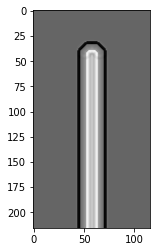

In [467]:
plt.imshow(optimal_images[1][0],cmap="Greys_r")

In [466]:
optimal_images[1]

(array([0.67306878, 0.22417062, 0.73232996, 0.        , 0.        ,
        1.01604698]),
 array([[[0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925],
         [0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925],
         [0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925],
         ...,
         [0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925],
         [0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925],
         [0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925]],
 
        [[0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925],
         [0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925],
         [0.46267925, 0.46267925, 0.46267925, ..., 0.46267925,
          0.46267925, 0.46267925],
         ..